# **[作業]電商如何以A/B Test 驗證新網頁設計有效**
## **Can eCommerce UX change boost the conversion rate from 0.13 to 0.15?**
知識點:

*   effect size
*   sample size for A/B test 
*   type I error = 0.05 and Power= 0.8
*   z-score, confidence interval

參考：A/B testing: A step-by-step guide in Python by Renato Fillinich @ medium.com

數據 : ab_data.csv from Kaggle

# **[作業目標]**

1.   了解Binomial分布，以及用常態分布求統計解的方法
2.   判讀A/B Test 結果



# **[作業重點]**



1.   如何決定最小樣本數
2.   如何以Z值，p-Value和信賴區間(Confidence Interval)判斷A/B結果是否顯著



# 作業：判讀程式最後統計結果，A/B test 是否顯著

z statistic: -0.34

p-value: 0.732

ci 95% for control group: [0.114, 0.133]

ci 95% for treatment group: [0.116, 0.135]

# 作業：試以(0.12, 0.11)計算結果是否顯著


# 作業：樣本數是以那些模組/函數算的

In [3]:
# import packages
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import scipy.stats as stats
import seaborn as sns
import statsmodels.stats.api as sms
from math import ceil

%matplotlib inline

# some plot styling references
plt.style.use("seaborn-whitegrid")
font = {
    "family": "Helvetica",
    "weight": "bold",
    "size":14
}
mpl.rc("font", **font)

# Caculating sample size
effect_size = sms.proportion_effectsize(0.13, 0.15)
required_n = sms.NormalIndPower().solve_power(
    effect_size,
    power=0.8,
    alpha=0.05,
    ratio=1
)
required_n = ceil(required_n)
print(required_n)

4720


In [4]:
df_data = pd.read_csv("ab_data.csv", encoding="utf-8")
df_data.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


In [5]:
df_data.info()

pd.crosstab(df_data["group"], df_data["landing_page"])

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   user_id       294478 non-null  int64 
 1   timestamp     294478 non-null  object
 2   group         294478 non-null  object
 3   landing_page  294478 non-null  object
 4   converted     294478 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 11.2+ MB


landing_page,new_page,old_page
group,,
control,1928,145274
treatment,145311,1965


In [6]:
bool_series = df_data["user_id"].duplicated(keep="first")
# passing NOT of bool_series to see unique values only
df_data = df_data[~bool_series]
df_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 290584 entries, 0 to 294477
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   user_id       290584 non-null  int64 
 1   timestamp     290584 non-null  object
 2   group         290584 non-null  object
 3   landing_page  290584 non-null  object
 4   converted     290584 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 13.3+ MB


In [7]:
# to make sure there are no duplicates in the "user_id"
df_data["user_id"].value_counts(ascending=False).sum()

290584

In [12]:
control_sample = df_data[df_data["group"]=="control"].sample(n=required_n, random_state=22)
treatment_sample = df_data[df_data["group"]=="treatment"].sample(n=required_n, random_state=22)

ab_test = pd.concat([control_sample, treatment_sample], axis=0)
ab_test.reset_index(drop=True, inplace=True)
ab_test

,user_id,timestamp,group,landing_page,converted
0,932413,2017-01-05 02:29:35.769705,control,old_page,0
1,660163,2017-01-23 12:28:57.530784,control,old_page,0
2,923145,2017-01-04 08:34:14.986015,control,old_page,0
3,798423,2017-01-05 17:15:58.968362,control,old_page,0
4,640448,2017-01-16 11:00:46.360932,control,old_page,0
...,...,...,...,...,...
9435,879385,2017-01-19 06:30:04.289006,treatment,new_page,0
9436,633855,2017-01-08 18:17:20.403731,treatment,new_page,0
9437,741596,2017-01-23 17:28:42.862009,treatment,new_page,0
9438,903058,2017-01-19 16:32:05.603197,treatment,new_page,0


In [13]:
ab_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9440 entries, 0 to 9439
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   user_id       9440 non-null   int64 
 1   timestamp     9440 non-null   object
 2   group         9440 non-null   object
 3   landing_page  9440 non-null   object
 4   converted     9440 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 368.9+ KB


In [15]:
ab_test["group"].value_counts()

treatment    4720
control      4720
Name: group, dtype: int64

In [21]:
conversion_rates = ab_test.groupby("group")["converted"]
std_p = lambda x: np.std(x, ddof=0)
se_p = lambda x: stats.sem(x, ddof=0)

conversion_rates = conversion_rates.agg([np.mean, std_p, se_p])
conversion_rates.columns = ["conversion_rates", "std", "std_error"]

conversion_rates.style.format("{:.3f}")

,conversion_rates,std,std_error
group,,,
control,0.117,0.321,0.005
treatment,0.132,0.338,0.005


Text(0, 0.5, 'Converted (proportation)')

findfont: Font family ['Helvetica'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Helvetica'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Helvetica'] not found. Falling back to DejaVu Sans.


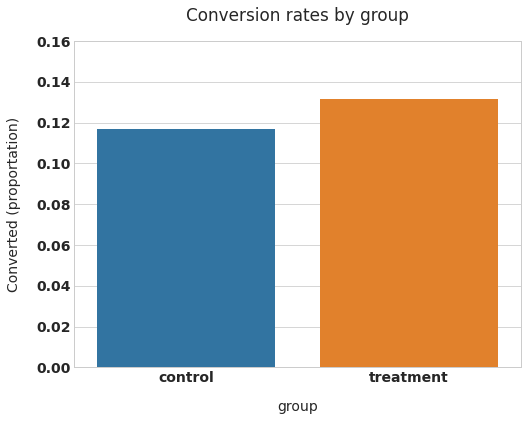

In [24]:
plt.figure(figsize=(8,6))
sns.barplot(
    x=ab_test["group"],
    y=ab_test["converted"],
    ci=False
)
plt.ylim(0, 0.16)
plt.title("Conversion rates by group", pad=20)
plt.xlabel("group", labelpad=15)
plt.ylabel("Converted (proportation)", labelpad=15)

In [39]:
from statsmodels.stats.proportion import proportions_ztest, proportion_confint
control_results = ab_test[ab_test["group"]=="control"]["converted"]
treatment_results = ab_test[ab_test["group"]=="treatment"]["converted"]
successes = [control_results.sum(), treatment_results.sum()]
nobs = [control_results.count(), treatment_results.count()]

z_stat, pval = proportions_ztest(successes, nobs=nobs)
(lower_con, lower_treat), (upper_con, upper_treat) = proportion_confint(successes, nobs=nobs, alpha=0.05)

print(f"z statistics: {z_stat: .2f}")
print(f"p value: {pval: .3f}")
print(f"CI for control group: [{lower_con:.3f}, {upper_con:.3f}]")
print(f"CI for treatment group: [{lower_treat:.3f}, {upper_treat:.3f}]")
# cannot reject null hypothesis

z statistics: -2.22
p value:  0.027
CI for control group: [0.108, 0.126]
CI for treatment group: [0.122, 0.141]


In [40]:
# 作業：試以(0.12, 0.11)計算結果是否顯著
# Caculating sample size
effect_size = sms.proportion_effectsize(0.12, 0.11)
required_n = sms.NormalIndPower().solve_power(
    effect_size,
    power=0.8,
    alpha=0.05,
    ratio=1
)
required_n = ceil(required_n)
print(required_n)

15970


In [41]:
control_sample = df_data[df_data["group"]=="control"].sample(n=required_n, random_state=22)
treatment_sample = df_data[df_data["group"]=="treatment"].sample(n=required_n, random_state=22)

ab_test = pd.concat([control_sample, treatment_sample], axis=0)
ab_test.reset_index(drop=True, inplace=True)
ab_test

,user_id,timestamp,group,landing_page,converted
0,932413,2017-01-05 02:29:35.769705,control,old_page,0
1,660163,2017-01-23 12:28:57.530784,control,old_page,0
2,923145,2017-01-04 08:34:14.986015,control,old_page,0
3,798423,2017-01-05 17:15:58.968362,control,old_page,0
4,640448,2017-01-16 11:00:46.360932,control,old_page,0
...,...,...,...,...,...
31935,674671,2017-01-12 22:06:29.741806,treatment,new_page,0
31936,823280,2017-01-18 09:44:08.998149,treatment,new_page,0
31937,819476,2017-01-24 12:56:38.486290,treatment,new_page,0
31938,812063,2017-01-16 06:34:12.787040,treatment,new_page,0


In [42]:
conversion_rates = ab_test.groupby("group")["converted"]
std_p = lambda x: np.std(x, ddof=0)
se_p = lambda x: stats.sem(x, ddof=0)

conversion_rates = conversion_rates.agg([np.mean, std_p, se_p])
conversion_rates.columns = ["conversion_rates", "std", "std_error"]

conversion_rates.style.format("{:.3f}")

,conversion_rates,std,std_error
group,,,
control,0.120,0.325,0.003
treatment,0.120,0.326,0.003


In [43]:
control_results = ab_test[ab_test["group"]=="control"]["converted"]
treatment_results = ab_test[ab_test["group"]=="treatment"]["converted"]
successes = [control_results.sum(), treatment_results.sum()]
nobs = [control_results.count(), treatment_results.count()]

z_stat, pval = proportions_ztest(successes, nobs=nobs)
(lower_con, lower_treat), (upper_con, upper_treat) = proportion_confint(successes, nobs=nobs, alpha=0.05)

print(f"z statistics: {z_stat: .2f}")
print(f"p value: {pval: .3f}")
print(f"CI for control group: [{lower_con:.3f}, {upper_con:.3f}]")
print(f"CI for treatment group: [{lower_treat:.3f}, {upper_treat:.3f}]")
# cannot reject null hypothesis

z statistics: -0.22
p value:  0.823
CI for control group: [0.115, 0.125]
CI for treatment group: [0.115, 0.126]
